In [2]:
import csv
import os

import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv('data/train.csv', index_col='id')

In [4]:
# Show the data
data

,y,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x17797,x17798,x17799,x17800,x17801,x17802,x17803,x17804,x17805,x17806
id,,,,,,,,,,,,,,,,,,,,,
0,0,-13,-9,-6,-4,0,2,6,12,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,-34,110,249,390,527,639,721,777,823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,-34,-36,-37,-39,-41,-42,-44,-46,-48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,292,298,303,310,320,336,354,377,405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,157,179,195,210,217,222,226,228,231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,3,-247,-271,-285,-303,-334,-376,-413,-432,-443,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5113,0,62,62,61,61,61,61,61,61,61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5114,0,-95,-110,-124,-131,-126,-114,-95,-67,-42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Retrieve one sample recording per class for plotting
labels_array = data['y'].to_numpy()
num_classes = 4
sample_signal_ids = []
for class_id in range(num_classes):
    sample_signal_ids.append(int(np.argwhere(labels_array == class_id)[0]))
    
# Print indices of the sample signals
sample_signal_ids

/tmp/ipykernel_129192/3491064012.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_signal_ids.append(int(np.argwhere(labels_array == class_id)[0]))


[0, 3, 4, 30]

## Pay attention to NaN values! 

Unlike many medical application, these NaNs **DO NOT** represent missing values but appear because of variable length of the signals. ECG recordings normally don't have missing values and are sampled equally.

Despite being put into a tabular CSV format / Pandas Dataframe, the data is still a raw signal with variable lengths. Coumns *x0, ..., x17806* correspond to measurements at time stamps *0, ..., 17806* and not to different features of the data point. If the signal is too short then all the coumns after the last measurement have NaN values,

In [6]:
# Get the raw recording without Nan values as a NumPy array
sample_data = data.loc[sample_signal_ids[1]].dropna().to_numpy(dtype='float32')

# Extracting heartbeat templates

In [7]:
r_peaks = ecg.engzee_segmenter(sample_data, sampling_rate=300)['rpeaks']
len(r_peaks)

70

In [8]:
beats = ecg.extract_heartbeats(sample_data, r_peaks, sampling_rate=300)['templates']
beats

array([[ 130.,  133.,  135., ..., -257., -255., -252.],
       [ -94., -123., -149., ..., -457., -635., -710.],
       [ 249.,  250.,  251., ..., -226., -229., -231.],
       ...,
       [ 109.,  108.,  105., ...,  458.,  500.,  491.],
       [ 204.,  199.,  194., ..., -586., -527., -414.],
       [ 156.,  161.,  168., ..., -105., -111., -116.]], dtype=float32)

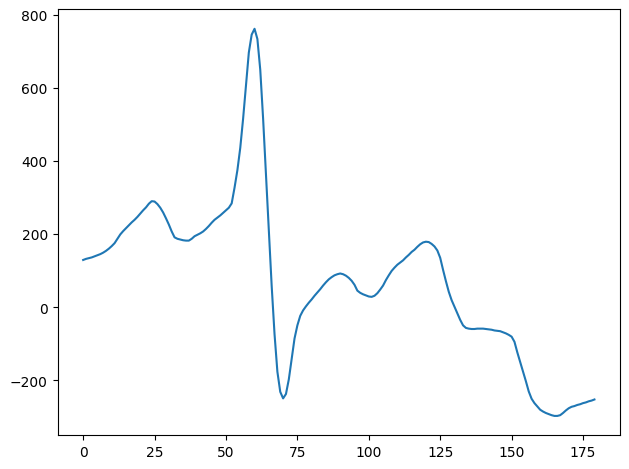

In [9]:
# plot one heartbeat template
plt.plot(beats[0])
plt.tight_layout()
plt.show()

# Plot sample signals for each class

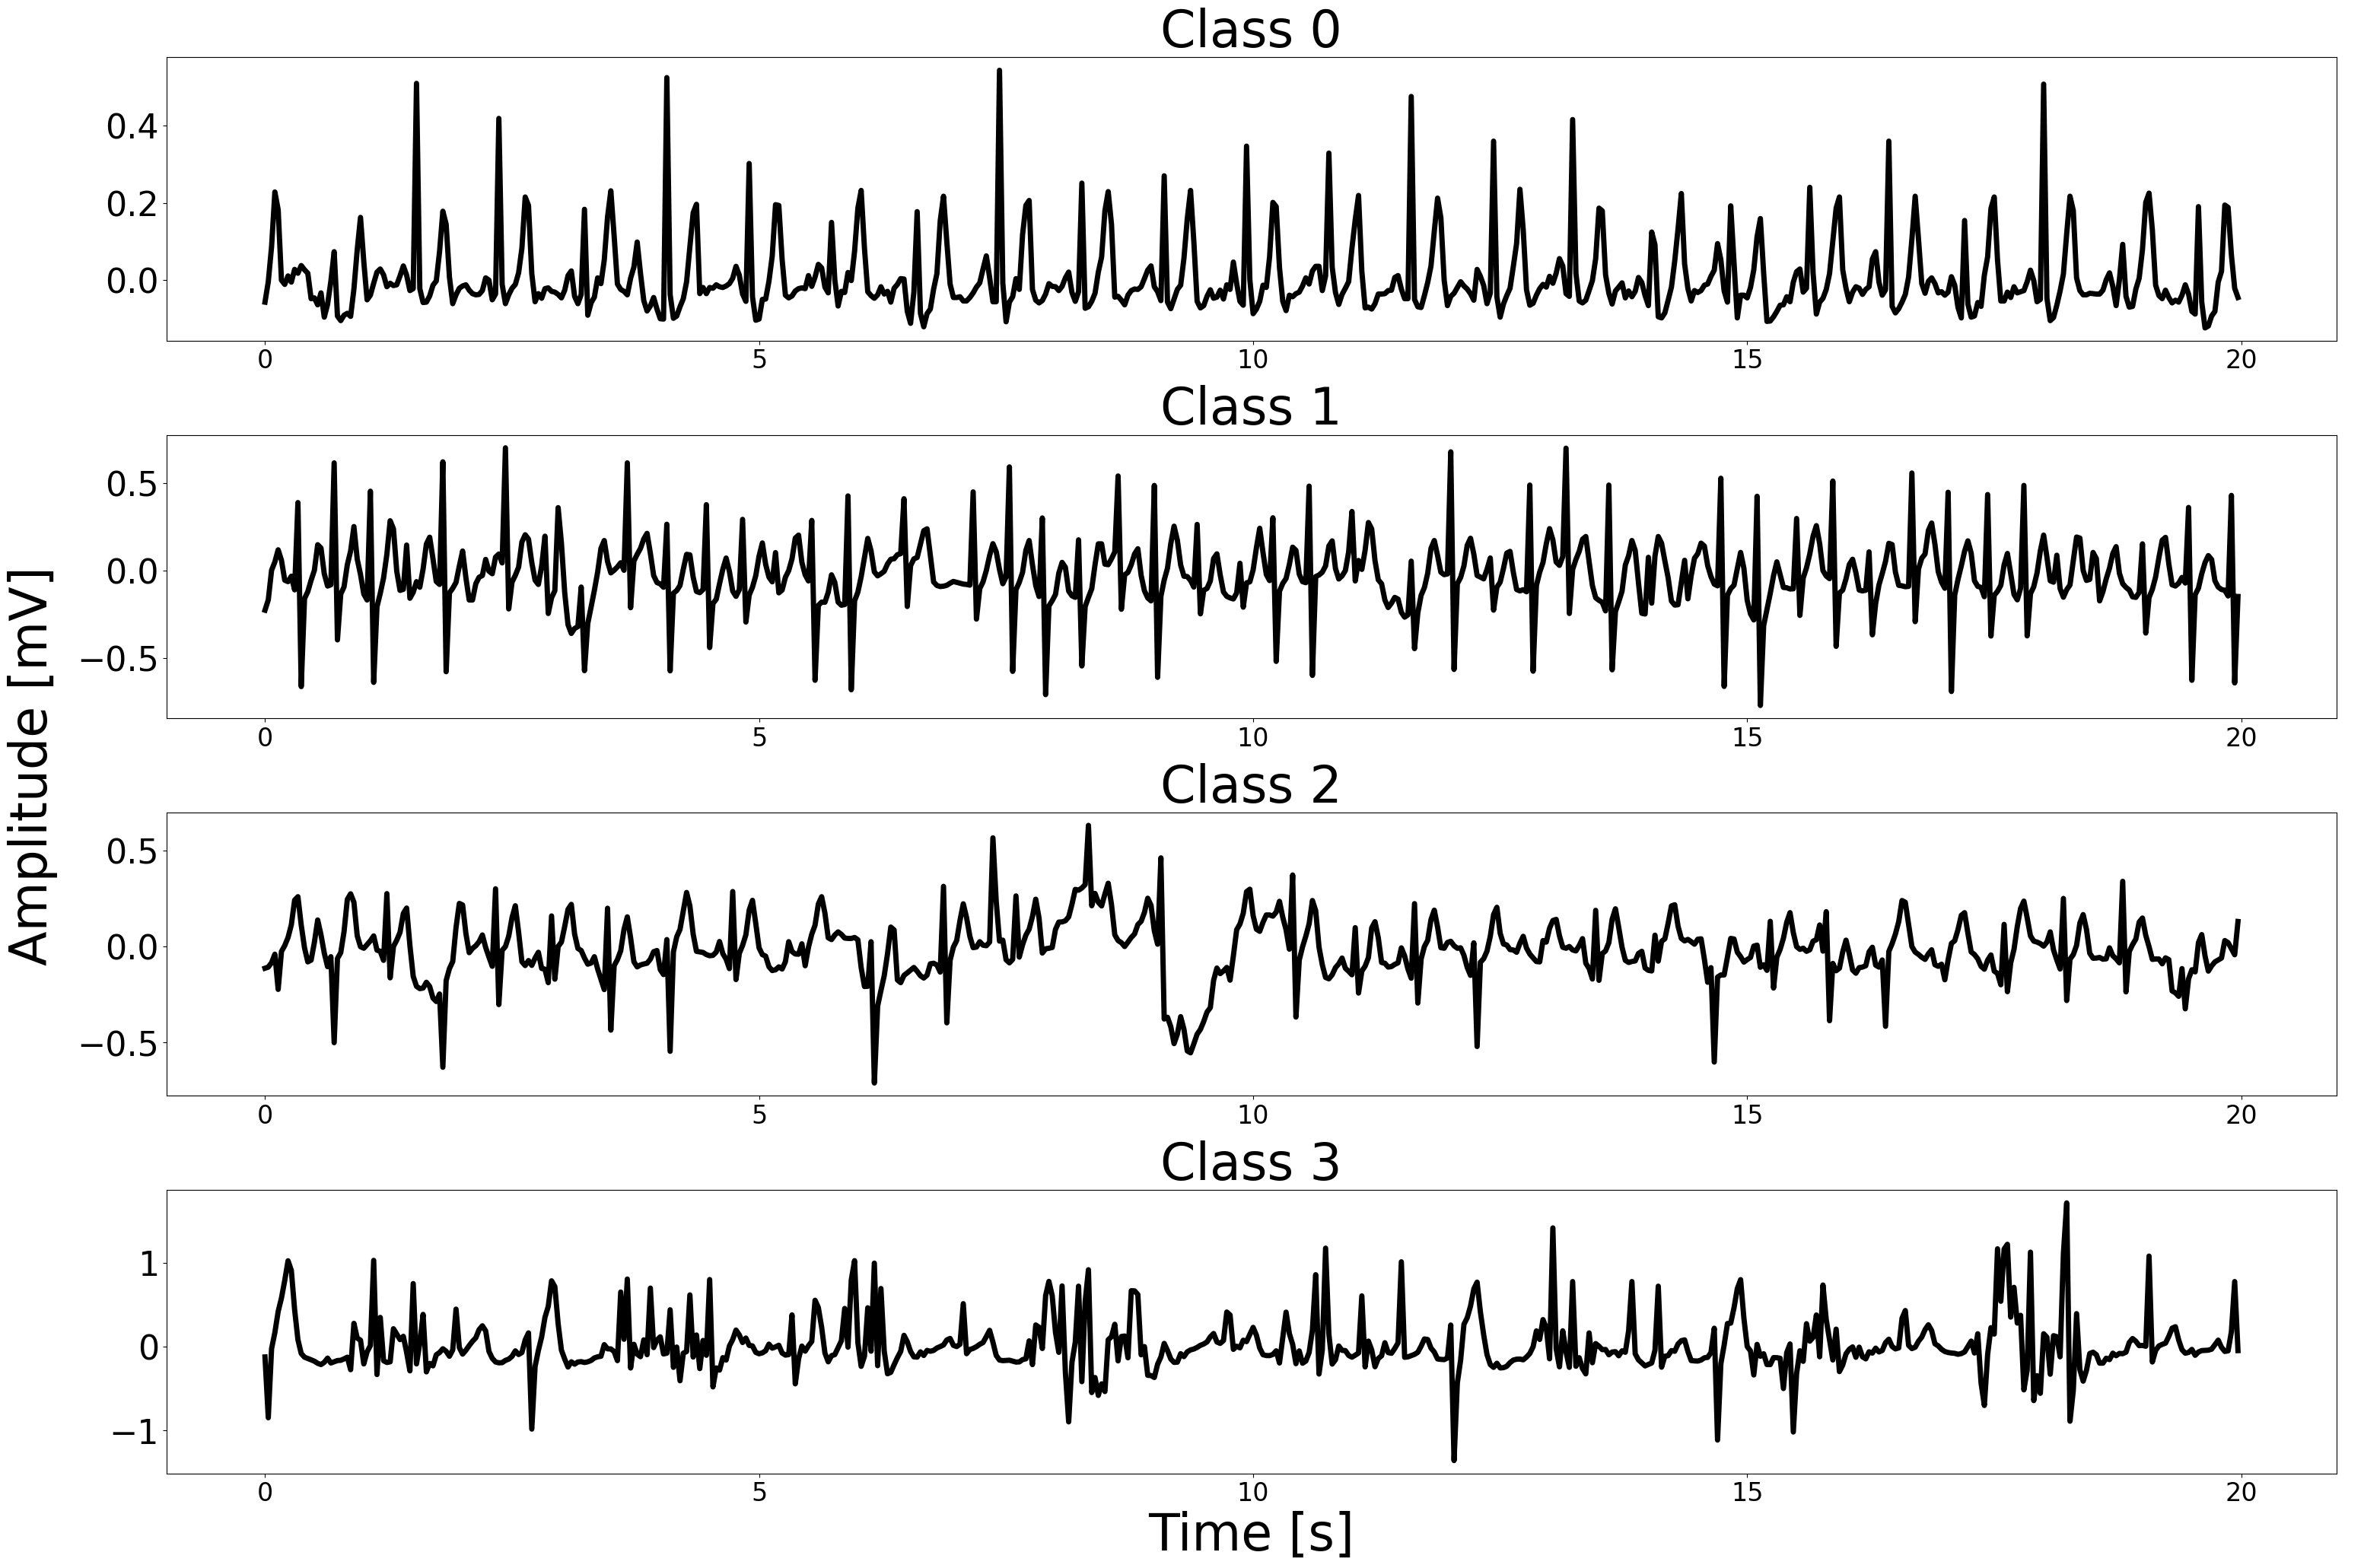

In [10]:
# Some matplotlib setting 
plt.rcParams["figure.figsize"] = (30, 20)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 32
plt.rcParams['axes.labelsize'] = 48
plt.rcParams['axes.titlesize'] = 48

fig, axs = plt.subplots(4, 1)

seconds = np.arange(0, 600) / 30 
x_labels = [0, 5, 10, 15, 20]

for class_id in range(num_classes):
    ax = axs[class_id]
    ax.set_title("Class {}".format(class_id))
    
    measurements = data.loc[sample_signal_ids[class_id]].dropna().to_numpy(dtype='float32')
    # Get a subsequence of a signal and downsample it for visualization purposes
    measurements = measurements[1000:7000:10] 
    # convert volts to millivolts
    measurements /= 1000
    ax.plot(seconds, measurements, color='k')
    ax.set_xticks(x_labels)
          
fig.tight_layout()

# Display x- and y-labels for the whole plot
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.yaxis.set_label_coords(-0.05, 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')            
plt.show()

In [47]:
def plot_features(signal):
    r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
    # print(r_peaks)
    if len(r_peaks) >= 2:
        # print(ecg.extract_heartbeats(signal, r_peaks, 300))
        beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0) 
            var = np.std(beats, axis=0)
            md = np.median(beats, axis=0)
            
            plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat', color='blue')
            # Fill the variance range
            plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
            # Plot a median
            plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='orange')

C:\Users\harry\AppData\Local\Temp\ipykernel_27304\1758671411.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='orange')


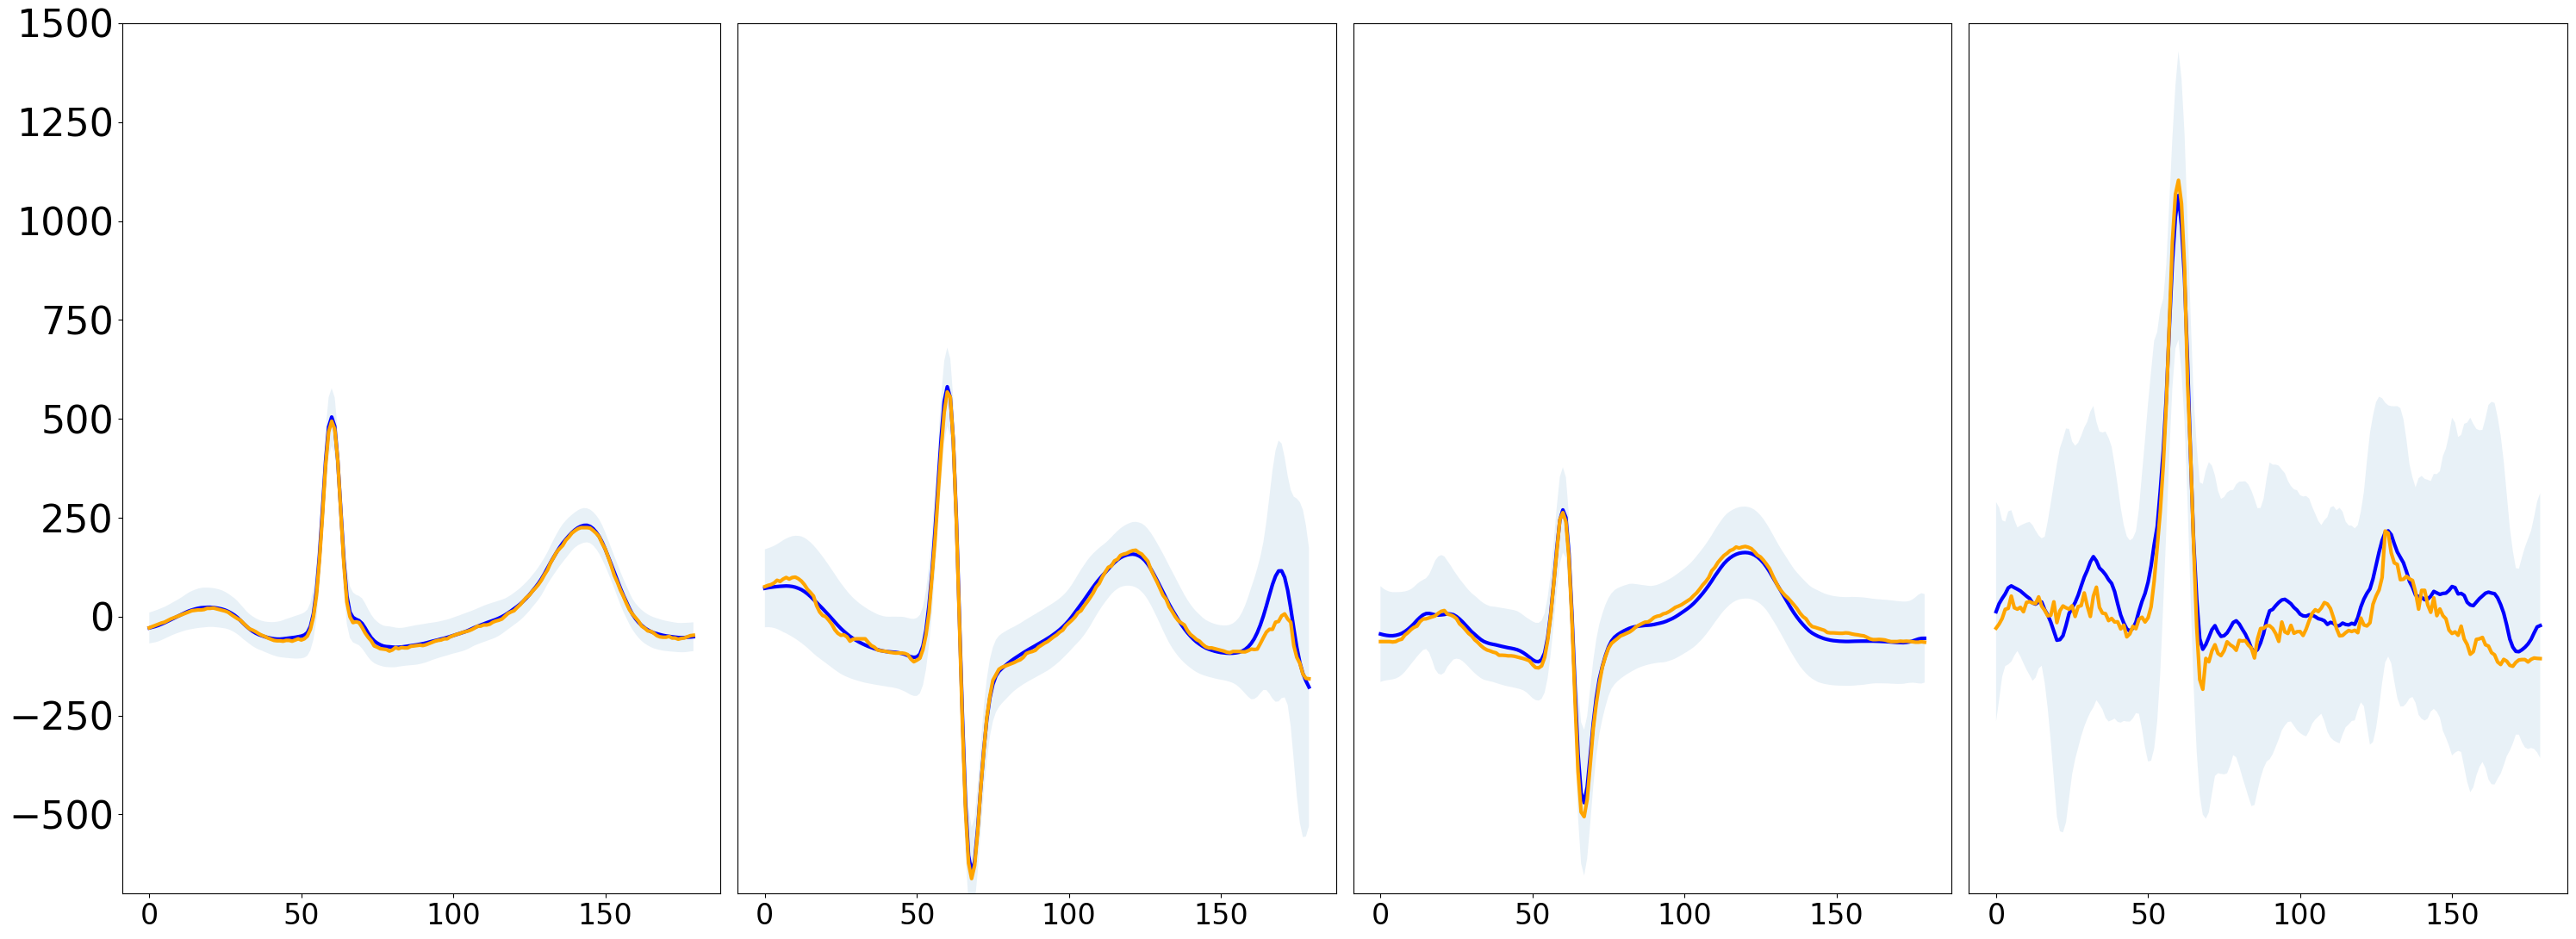

In [48]:
plt.rcParams['lines.linewidth'] = 3
plt.figure(figsize=(30, 11))
for class_id in range(num_classes):
    ax = plt.subplot(1, 4, class_id + 1)
    #ax.set_title("Class {}".format(class_id))
    ax.set_ylim([-700, 1500])
    if class_id:
        ax.set_yticks([])
    plot_features(data.loc[sample_signal_ids[class_id]].dropna().to_numpy(dtype='float32'))

plt.tight_layout()
plt.show()